# 音の違いを学習

In [1]:
import datetime
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import tcn  # https://pypi.org/project/keras-tcn/

%matplotlib inline

In [2]:
import import_ipynb
import functions as myfunc

myfunc.setup_seed(123)

importing Jupyter notebook from functions.ipynb


## TFRecordファイルからデータ読み込み


In [3]:
CLIP_SAMPLES = 24000  # 各クリップのサンプル数


def decode_example(example):
    features = tf.io.parse_example(
        example,
        features={
            "audio": tf.io.FixedLenFeature([CLIP_SAMPLES], dtype=tf.float32),
            "label": tf.io.FixedLenFeature([], dtype=tf.int64),
        },
    )
    audio = tf.expand_dims(features["audio"], -1)  # 削っていたサイズ1の次元を追加（Numpyではなくtf操作）
    label = features["label"]
    return audio, label


def read_clips(filename: str, batch_size=128):
    return (
        tf.data.TFRecordDataset([filename])
        .batch(batch_size)
        .map(decode_example)
        .unbatch()
    )

In [4]:
# Dataset形式でTFRecordファイルを読み込む
ds_l = read_clips("./data/snare_l.tfrecord")
ds_r = read_clips("./data/snare_r.tfrecord")

# 結合
ds = ds_l.concatenate(ds_r)
print(f"ds: {myfunc.cardinality(ds)} clips")

ds: 1152 clips


## データを学習用/検証用に分割する

In [5]:
def split_data(ds: tf.data.Dataset, ratio=0.8, batch_size=32):
    ds_size = myfunc.cardinality(ds)
    split_pos = int(ds_size * ratio)

    # シャッフルしてデータを分割
    # batch > map > cache > (map) > prefetch の順番を推奨
    # reshuffleを無効化してエポックごとにtake/skipのデータが混ざらないようにする
    # shuffle後にcacheを入れるとシャッフルされなくなるので注意
    ds = ds.shuffle(ds_size, reshuffle_each_iteration=False)
    ds_x = (
        ds.take(split_pos)
        .cache()
        .shuffle(split_pos, reshuffle_each_iteration=True)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    ds_y = ds.skip(split_pos).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

    # 情報表示
    cx, cy = myfunc.cardinality(ds_x), myfunc.cardinality(ds_y)
    print(f"train/test batches:({cx},{cy}), batch_size:{batch_size}, ratio:{ratio}")
    return (ds_x, ds_y)

In [6]:
# 学習時にGPUメモリ不足になる場合はバッチサイズを減らす
ds_train, ds_test = split_data(ds, ratio=0.70, batch_size=32)

train/test batches:(26,11), batch_size:32, ratio:0.7


## モデル作成

In [7]:
# モデルの定義
model = tf.keras.models.Sequential(
    [
        # https://pypi.org/project/keras-tcn/#arguments
        tcn.TCN(
            input_shape=(CLIP_SAMPLES, 1),
            nb_filters=64,  # default:64
            kernel_size=5,  # default:3
            dilations=(1, 2, 4, 8, 16, 32, 64, 128, 256, 512),  # 多い方が安定（増やしすぎもダメ）
            kernel_initializer="he_uniform",
            dropout_rate=0.03,  # TCNの場合はDropoutを大きくしない
            use_layer_norm=True,  # batch_normを使うと精度が大きく落ちる
        ),
        L.Dense(2),  # softmaxは使わない
    ]
)
tcn.tcn_full_summary(model, expand_residual_blocks=False)

# モデルのコンパイル
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer="adam",
    loss=loss_fn,
    metrics=["accuracy"],
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block_0 (ResidualBl multiple                  21312     
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  41344     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  41344     
_________________________________________________________________
residual_block_3 (ResidualBl multiple                  41344     
_________________________________________________________________
residual_block_4 (ResidualBl multiple                  41344     
_________________________________________________________________
residual_block_5 (ResidualBl multiple                  41344     
_________________________________________________________________
residual_block_6 (ResidualBl multiple                  4

## 学習

In [8]:
# 学習が進まなくなった場合に学習率を変更する
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001, verbose=1
)
# 改善が見られなければ学習を停止し、最良のウェイト値に戻す
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)
# TensorBoard用
log_dir = f"./logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# 学習
history = model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_test,
    callbacks=[reduce_lr, early_stopping, tb_callback],
)

Epoch 1/30
26/26 [==============================] - 44s 1s/step - loss: 2.7701 - accuracy: 0.5677 - val_loss: 0.6388 - val_accuracy: 0.6503
Epoch 2/30
26/26 [==============================] - 32s 1s/step - loss: 0.4876 - accuracy: 0.7777 - val_loss: 0.3750 - val_accuracy: 0.8266
Epoch 3/30
26/26 [==============================] - 32s 1s/step - loss: 0.3745 - accuracy: 0.8281 - val_loss: 0.2971 - val_accuracy: 0.8642
Epoch 4/30
26/26 [==============================] - 32s 1s/step - loss: 0.3070 - accuracy: 0.8719 - val_loss: 0.1898 - val_accuracy: 0.9191
Epoch 5/30
26/26 [==============================] - 32s 1s/step - loss: 0.2370 - accuracy: 0.8890 - val_loss: 0.0940 - val_accuracy: 0.9884
Epoch 6/30
26/26 [==============================] - 32s 1s/step - loss: 0.1053 - accuracy: 0.9716 - val_loss: 0.0501 - val_accuracy: 0.9942
Epoch 7/30
26/26 [==============================] - 32s 1s/step - loss: 0.0652 - accuracy: 0.9693 - val_loss: 0.1967 - val_accuracy: 0.9017
Epoch 8/30
26/26 [==

### 学習履歴

val_lossの値は13エポックで最良となり、その後は3回連続で13エポック目よりも値が悪化している。  
そのため、最終的なモデルのウェイト値は、最良の13エポック目の値になる。（EarlyStoppingによるもの）

TensorBoard用の出力結果は、TensorBoard.dev (Preview)で共有可能。  
https://tensorboard.dev/experiment/dIKqxJYpQQSvAaPkIA5ClA/  
```tensorboard dev upload --logdir ./logs --name "tcn-snare" --description "Training results of a model that classifies snare drum hit locations."```


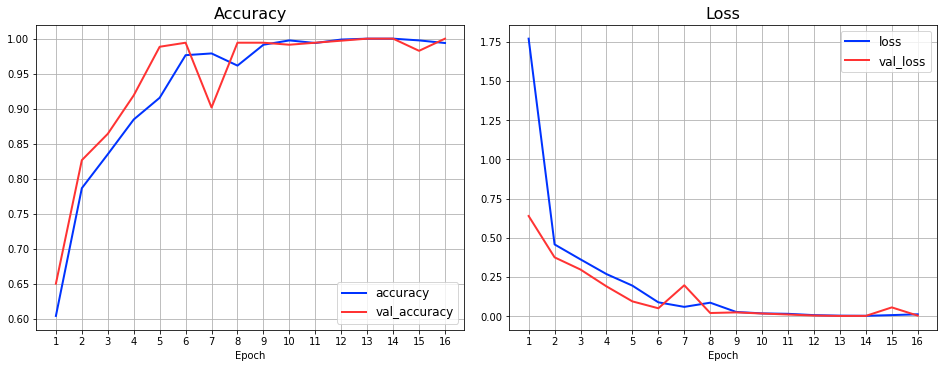

In [9]:
myfunc.show_history_graph(history)

## モデルの保存

In [10]:
# 保存
model.save("./model/tcn_snare")  # SavedModel形式

INFO:tensorflow:Assets written to: ./model/tcn_snare/assets


INFO:tensorflow:Assets written to: ./model/tcn_snare/assets
